## Categorising countries

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [128]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA


In [129]:
# Variable to keep consistent random_state
r = 42

## Load and explore data

In [130]:
# Import the dataset
df = pd.read_csv('Country-data.csv')

In [131]:
# Check the data's shape
df.shape

(167, 10)

In [132]:
# Check datatypes & counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [133]:
# Get descriptive statistics
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [134]:
# Identify any missing data
print(df.isnull().sum())

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


## Preprocessing and Feature Selection

In [135]:
# Set a training columns variable selecting everything in the dataframe but index point 0
training_columns = df.columns[1:]

In [136]:
# Drop any non-numeric features (columns)
df = df.drop('country', axis=1)
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


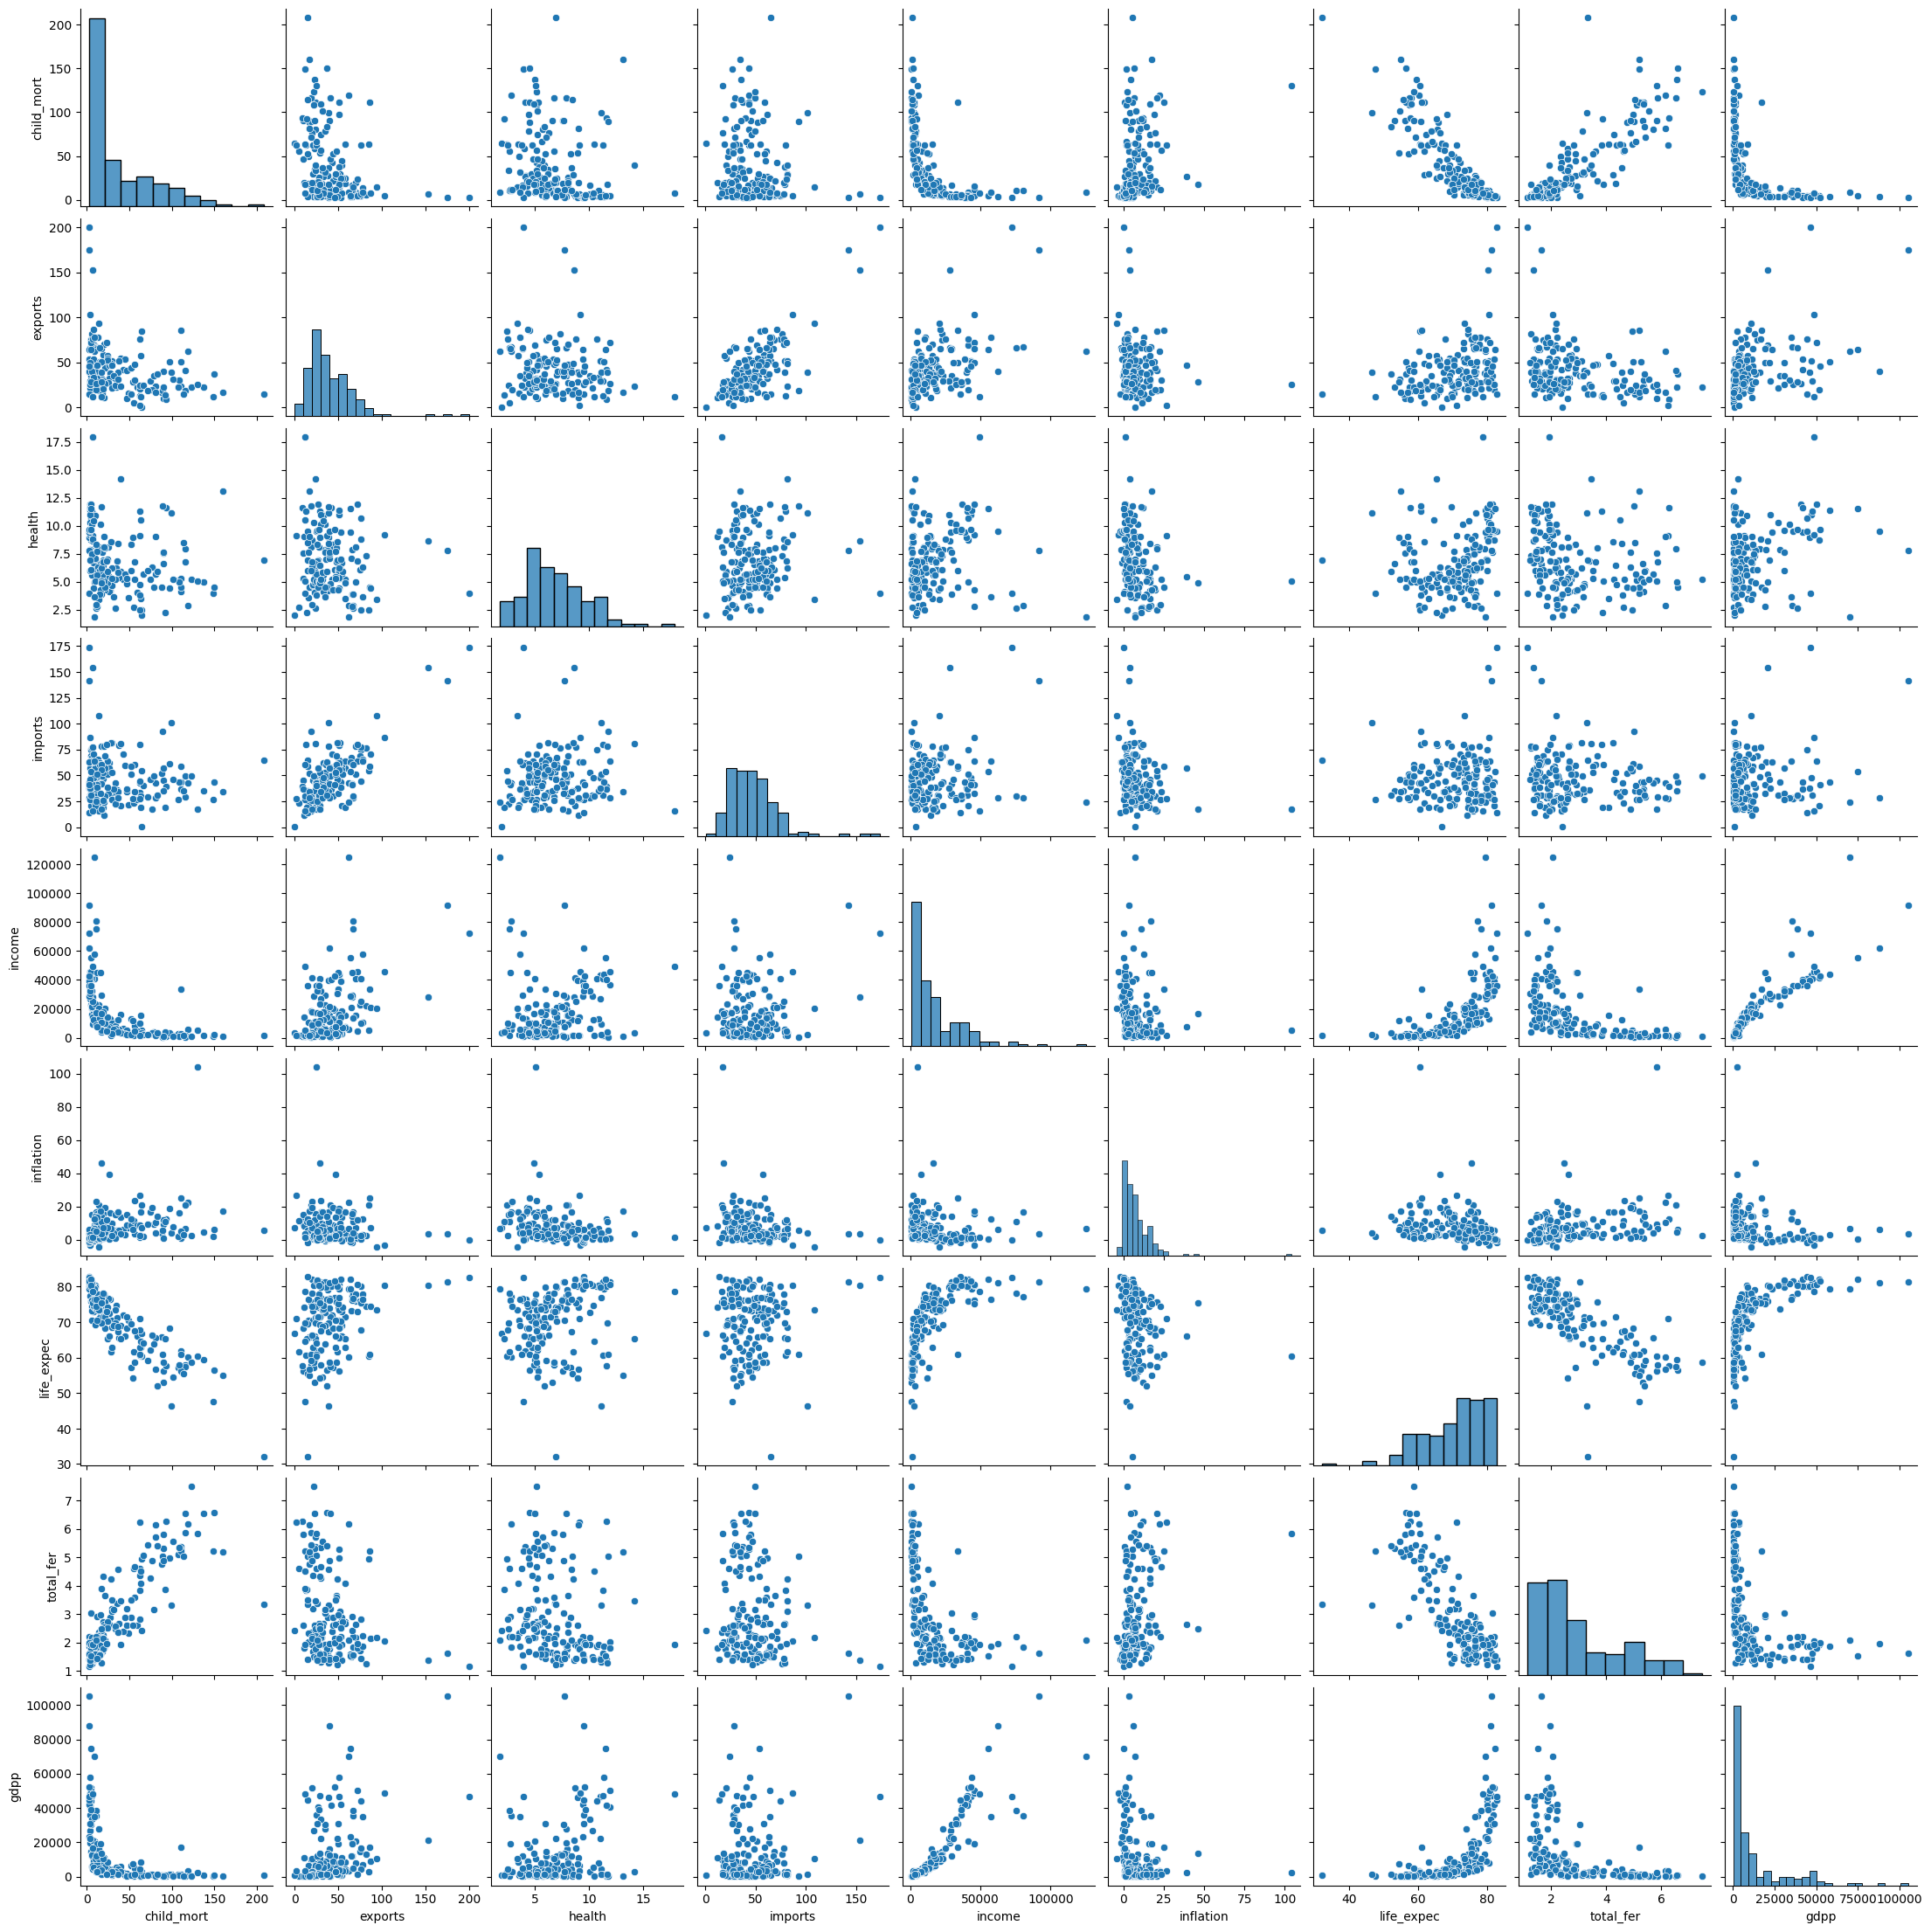

In [137]:
# Create a pair plot
# Hint: Explore seaborn pairplot
sns.pairplot(data=df)

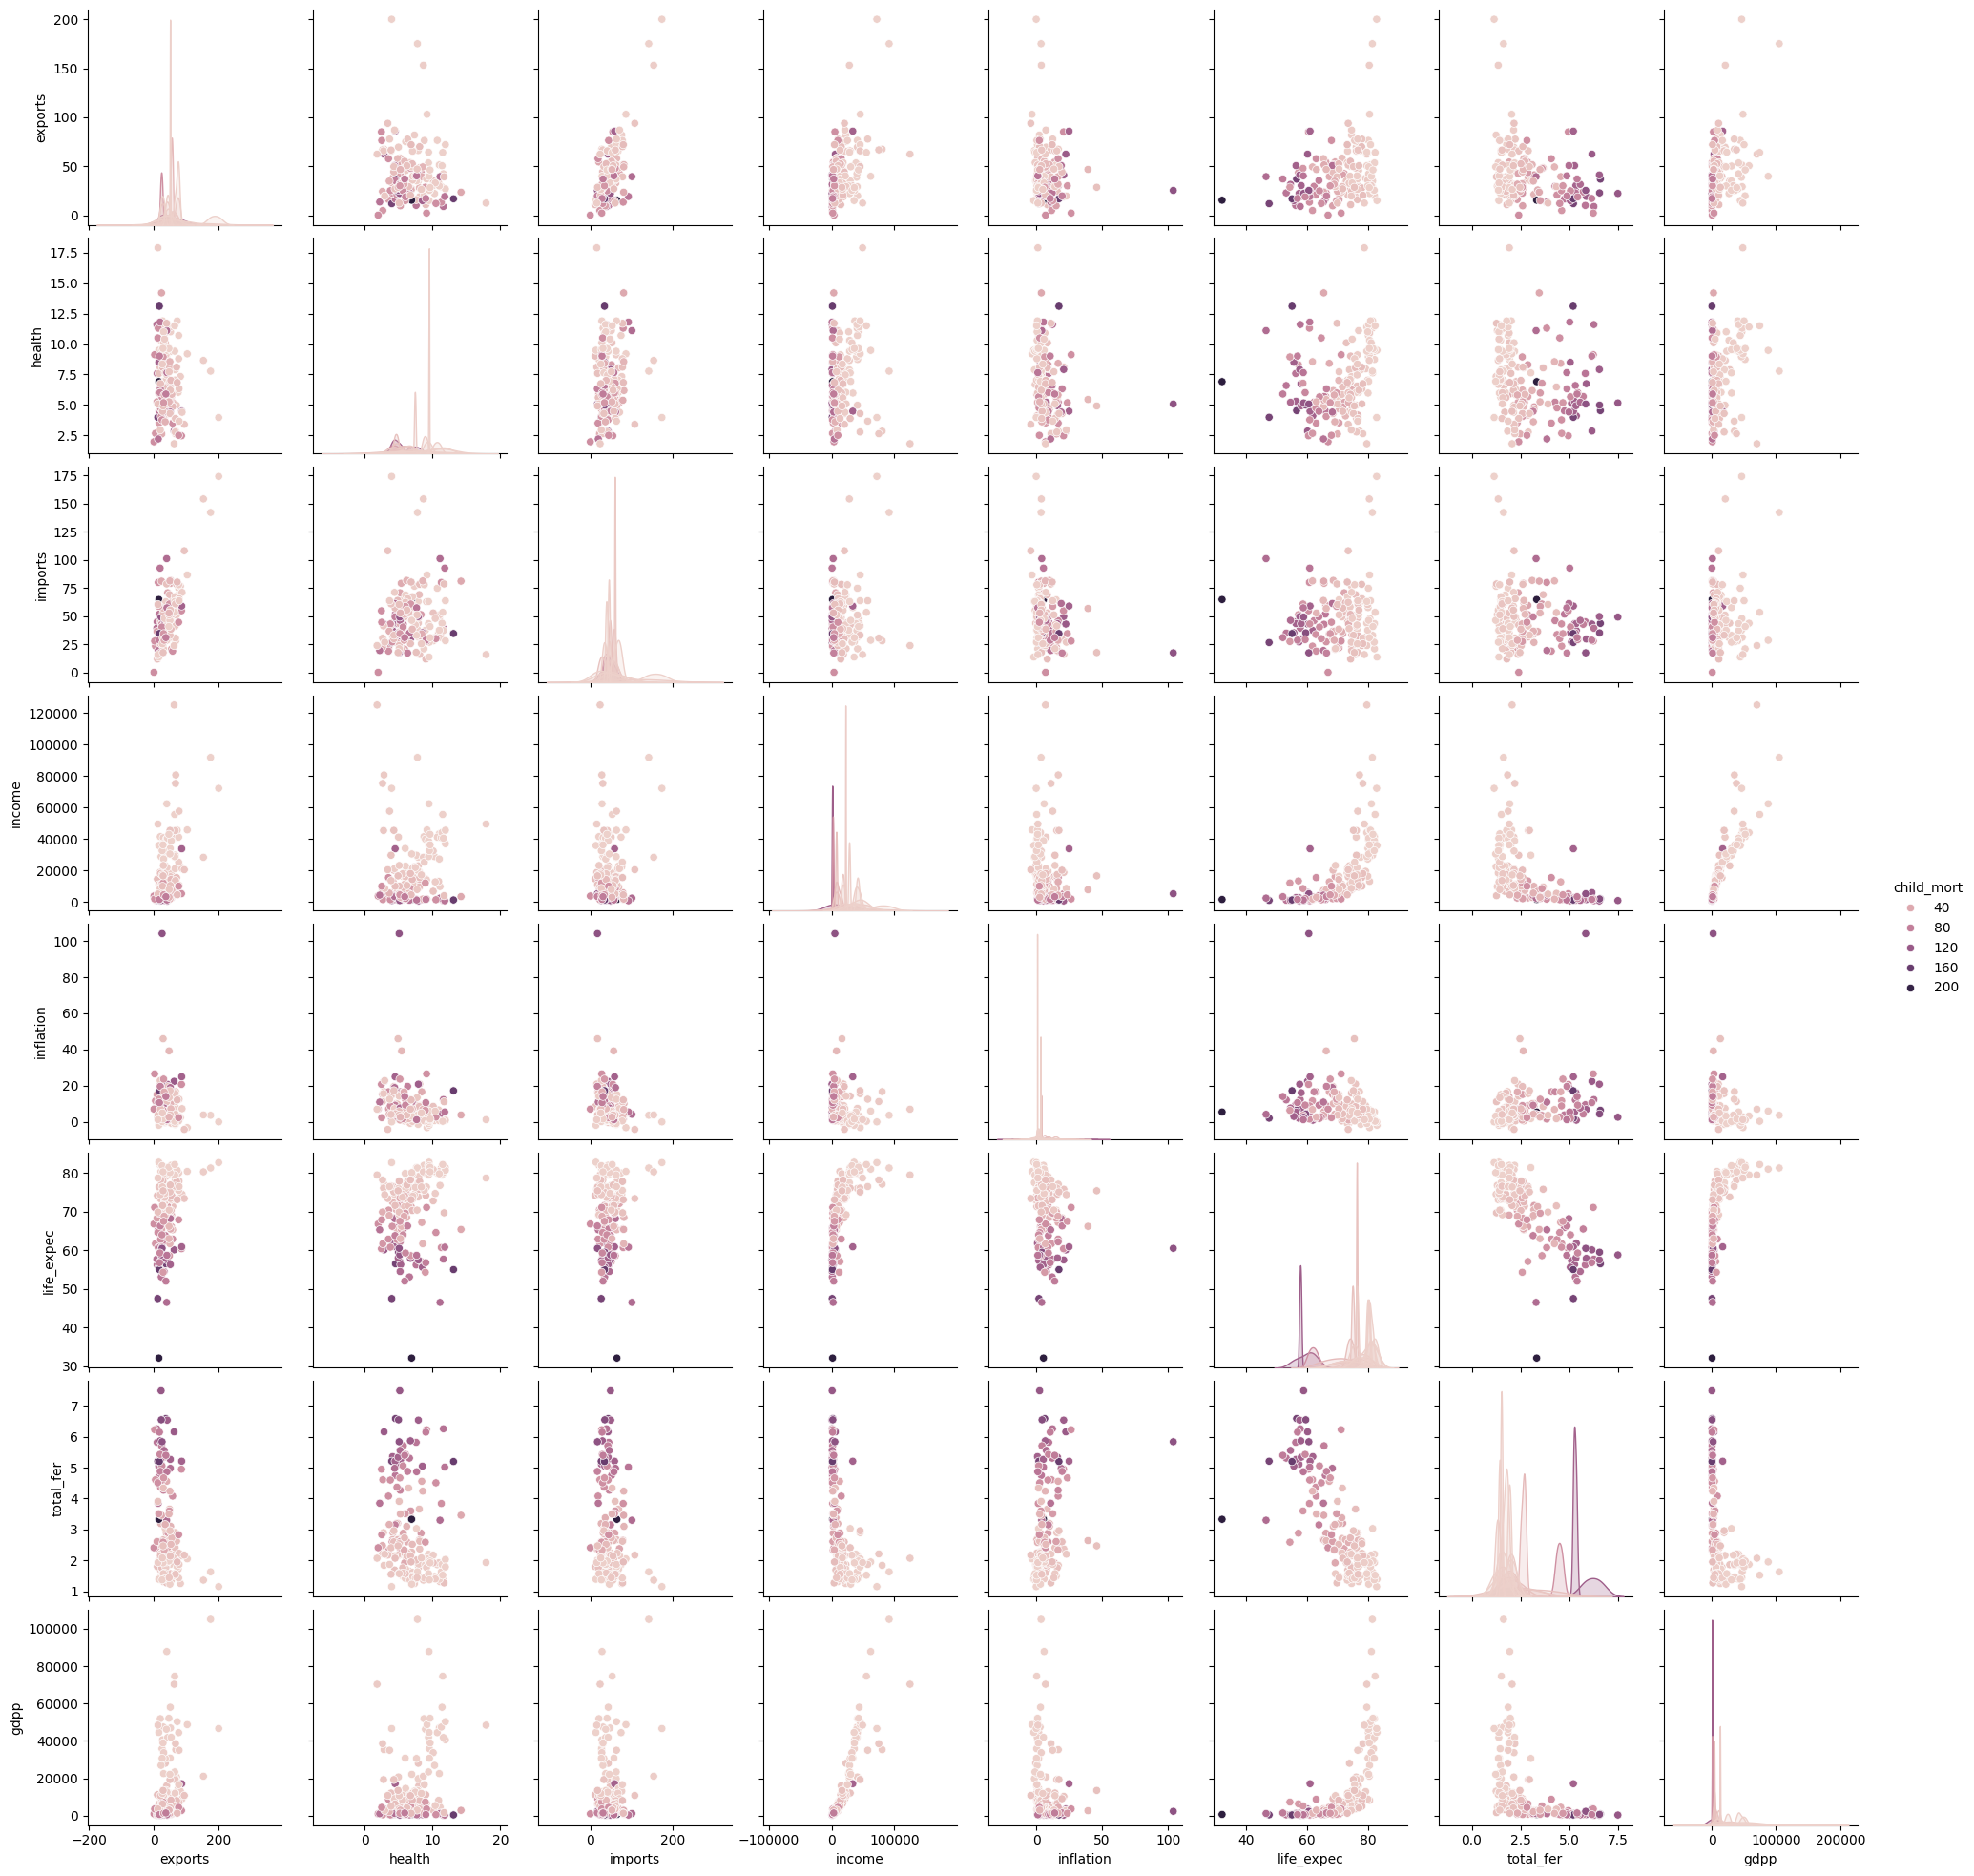

In [138]:
# Explore the continuous independent features against child_mort using scatter plots.
sns.pairplot(data=df, hue='child_mort')

<Axes: xlabel='income', ylabel='gdpp'>

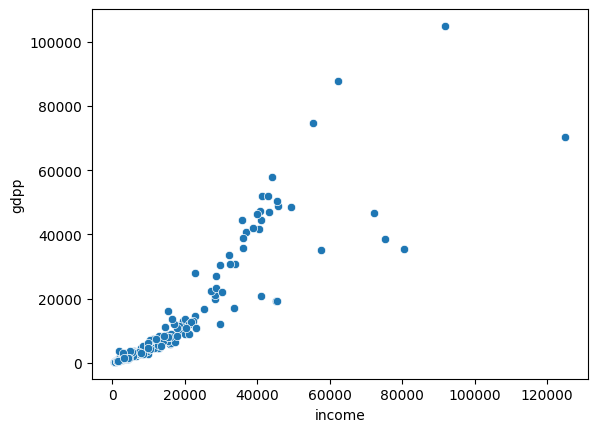

In [139]:
# Explore the continuous independent features against gdpp using scatter plots
# Insert which value we want to comapre against GDPP to keep the time complexity lower for this code
sns.scatterplot(data=df, x='income', y='gdpp')

### Scaling the Data

In [140]:
# Normalise the data using MinMaxScaler as the distribution looks non-gaussian
# Name the normalised dataframe "df_scaled"
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled, columns=df.columns)


## K-Means Clustering

### Selecting K

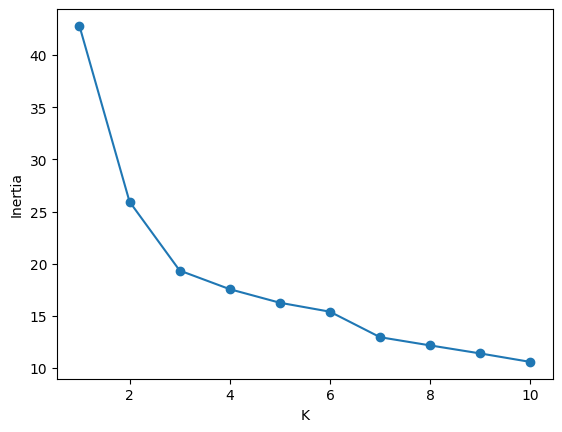

In [141]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

 # Plot elbow curve using scaled dataset

elbow_Kmeans(df_scaled)


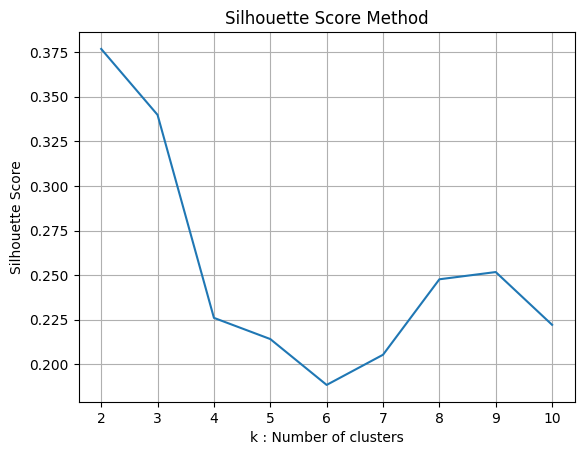

In [142]:
# Silhouette score method
# The silhouette graph also shows 3 is the optimal number of clusters as its where the score is highest (closest to 1)
# The elbow curve also shows 3 as the optimal cluster value, as it's a good balance between the inettia and cluster numbers
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

In [143]:
# Check model performance with the silhouette coefficient
# Set the labels to the kmeans values
kmeans_lables = kmeans.labels_
silhouette_average = silhouette_score(df_scaled, kmeans_lables)
print(f"Silhouette Score = {silhouette_average:.3f}")

Silhouette Score = 0.222


Based on the elbow and silhouette score method choose a value for K.

## Fitting a K-Means Model with the selected K value

In [144]:
# Set cluster value based on the insights of the silhouette & elbow model
k = 3
# Fit the KMeans model
kmeans = KMeans(n_clusters=k, random_state=r)
kmeans.fit(df_scaled)


KMeans(n_clusters=3, random_state=42)

In [145]:
# Add the predicted cluster label column to the original dataframe
df_scaled['Cluster'] = kmeans.labels_
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,2
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,0
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,0
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,2
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,0


In [146]:
#Count the number of records in each cluster
df_scaled.groupby('Cluster').mean()
# Give the Clusters names based on how they've grouped together
# As the highest values for positive attributes are majoritivley int he 1 group, this is the Most Economically Developed Country
clusters_named = {
    0: 'Medium Econcomically Developed Country',
    1: 'Most Econcomically Developed Country',
    2: 'Least Economically Developed Country'
}
# Map the cluster names to the values
df_scaled['Cluster'] = df_scaled['Cluster'].map(clusters_named)
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,Least Economically Developed Country
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,Medium Econcomically Developed Country
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,Medium Econcomically Developed Country
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,Least Economically Developed Country
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,Medium Econcomically Developed Country


## Predictions

In [147]:
# Making predictions based on an unseen curated data sample by using a dictionairy
test_country = pd.DataFrame({
    'child_mort': [0.6],
    'exports': [0.4],
    'health': [0.4],
    'imports': [0.2],
    'income': [0.05],
    'inflation': [0.1],
    'life_expec': [0.9],
    'total_fer': [0.8],
    'gdpp': [0.02]
}, columns=training_columns)

# Match the dictionairy dataset format of the training data
test_country = test_country[training_columns]

In [148]:
# Use MinMaxScaler on the data so it passes through the KMeans algorhythm
test_country_scaled = scaler.transform(test_country)
predicted_cluster = kmeans.predict(test_country_scaled)
# Print the result of which cluster it would fit in to. The clusters predicted the test set correctly
print(f"Predicted Status of Test Country: {clusters_named[predicted_cluster[0]]}")

Predicted Status of Test Country: Least Economically Developed Country


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


## Visualisation of clusters

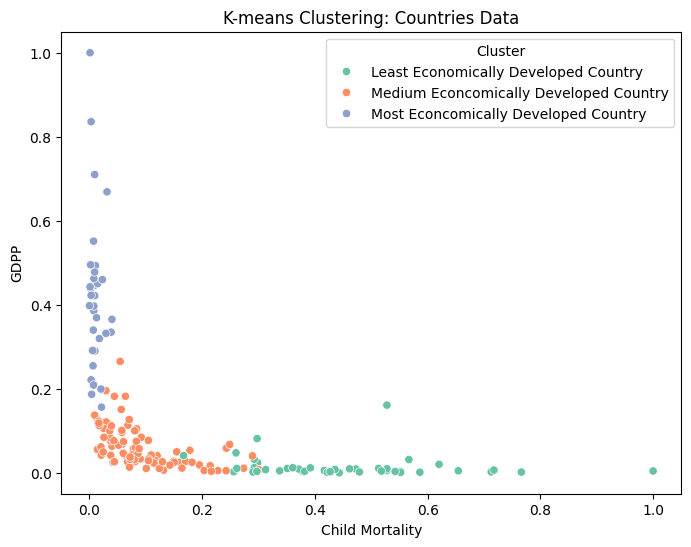

In [149]:
# Visualisation of clusters: child mortality vs gdpp, set the hue to the clusters to see the distribution
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_scaled['child_mort'], y=df_scaled['gdpp'], hue=df_scaled['Cluster'], palette='Set2')
plt.xlabel('Child Mortality')
plt.ylabel('GDPP')
plt.title('K-means Clustering: Countries Data')
plt.show()


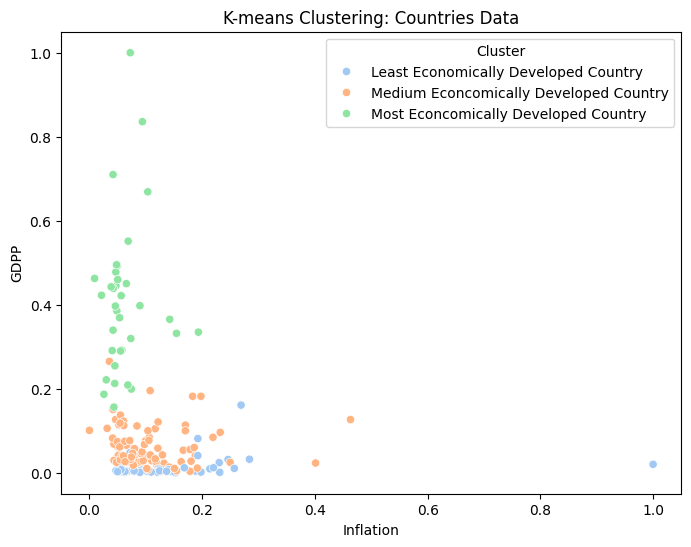

In [150]:
# Visualisation of clusters: inflation vs gdpp, set the hue to the cluster values to see the distribution
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_scaled['inflation'], y=df_scaled['gdpp'], hue=df_scaled['Cluster'], palette='pastel')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=200, linewidths=3, color='r')
plt.xlabel('Inflation')
plt.ylabel('GDPP')
plt.title('K-means Clustering: Countries Data')
plt.show()

## Conclusions

**Answer here:**

The labels for Medium/Most/Less Economically Developed Countries have been assigned to the appropriate K values. This KMeans method has helped group the presented features that correlate to such a group. As seen from the above visualisations for GDPP against 'Child Mortality' and 'Inflation', the clusters follow a similar trend that we would expect to see. The lower the 'Child Morality' rate, the higher the 'GDPP', the more dense the clusters belonging to 'Most Economically Developed Country' are. Likewise with 'Inflation' - the lower the inflation value paired with a higher 'GDPP', the more we see the pastel green points assigned to 'Most Economically Developed Country'. 

The only thing to imrpove from this model would be the handling of outliers - an updates version of this code could focus on handling outliers to ensure the KMeans model performs at it's most accurate capacity. 